In [1]:
import requests
import pandas as pd
import geopandas as gpd
import datashader as ds
from datashader import transfer_functions as tf
from datashader.utils import lnglat_to_meters
from tqdm import tqdm
from itertools import product
from colorcet import fire, blues, CET_CBTL3
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

c:\Users\s1759665\Miniconda3\envs\xdem_plancomp\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


In [ ]:
# for dividing up the world into smaller bboxs for then querying overpass turbo
# (yes, this could be better and not bother asking for peaks over the ocean...)
lons = range(-180,180, 10)
lats = range(-90,90,10)

# Define the Overpass Turbo query
overpass_url = "https://overpass-api.de/api/interpreter"

peaks = []
for lon,lat in tqdm(product(lons,lats)):
    west = lon
    south = lat
    east = lon+10
    north= lat+10
    
    ### query for getting ALL PEAKS in bbox
    overpass_query = """
    [out:json];
    (
        node["natural"="peak"](south,west,north,east);
    );
    out geom;
    """
    overpass_query = (overpass_query
                      .replace('south', str(south))
                      .replace('west', str(west))
                      .replace('north', str(north))
                      .replace('east', str(east))
                      )
    
    response = requests.post(overpass_url,
                         data=overpass_query)
    
    data = response.json()
    peak_points = [(peak['lon'], peak['lat']) for peak in data['elements']]

    peaks.append(peak_points)

In [ ]:
## flatten list of lists and convert to dataframe
## use datashaders convert to metres (although, don't use that in the end)
flattened = [val for sublist in peaks for val in sublist]
df = pd.DataFrame(flattened, columns=['lon','lat'])
df.loc[:,'easting'], df.loc[:,'northing'] = lnglat_to_meters(df['lon'],df['lat'])

# export -- so don't need to run the above again
df.to_feather('all_osm_peaks.feather')

In [2]:
# read in exported data
df = pd.read_feather('all_osm_peaks.feather')

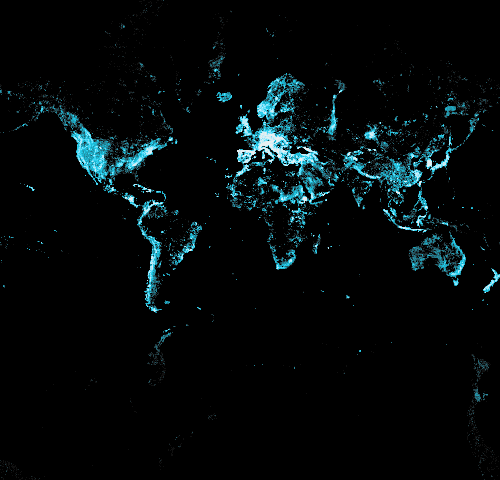

In [3]:
## plotting just with datashader
xmin,xmax = df['easting'].quantile([0.0001,0.9999])
ymin,ymax = df['northing'].quantile([0.0001,0.9999])
ratio = (ymax-ymin) / (xmax-xmin)

w = 500
cnv = ds.Canvas(plot_width=w,
                plot_height=round(w*ratio),
                y_range=(ymin, ymax),
                x_range=(xmin, xmax))
agg = cnv.points(df, 'easting', 'northing')
ds.tf.set_background(ds.tf.shade(agg, cmap=CET_CBTL3), "black")

#### HOW DO I ANNOTATE THIS!!

In [4]:
### couldn't work out how to annotate, or change the projection (tried holoviews and geoviews but find their api confusing)
### dump lat lon's into geopandas and reproject
coords = gpd.points_from_xy(df['lon'], df['lat'], crs=4326)
gdf = gpd.GeoDataFrame(geometry=coords, crs=4326)
gdf_prj = gdf.to_crs(ccrs.Robinson())

In [59]:
xmin, ymin, xmax, ymax = ccrs.Robinson().cw_boundary.bounds # set bounds to be projection bounds
ratio = (ymax-ymin) / (xmax-xmin)

w = 3000
cnv = ds.Canvas(plot_width=w,
                plot_height=round(w*ratio),
                y_range=(ymin, ymax),
                x_range=(xmin, xmax))
agg = cnv.points(gdf_prj, geometry='geometry')
img = ds.tf.set_background(ds.tf.shade(agg, cmap=CET_CBTL3), "black")
img_arr = img._to_temp_dataset() ############ this is the magic that retrieves the shaded xarray dataset, that can then be plotted easily with matplotlib

In [23]:
## convert colorcet's colormap to a matplotlib friendly one
cmap = LinearSegmentedColormap.from_list(colors = CET_CBTL3, name='cet_cbtl3')

fig, ax = plt.subplots(figsize=[16,16],
                       subplot_kw={'projection':ccrs.Robinson()})
img_arr[list(img_arr.keys())[0]].plot(ax=ax,
                                      cmap=cmap,
                                      add_colorbar=False)  # because the array has a weird name ('<this-array>')

ax.set_facecolor('k')

ax.set_title("tags={'natural':'peak'}",
             c='w',
             x=0.08,y=0.3, ha='left')

ax.annotate(text=f'all {len(df):,} of them',
            xy=(0.08,0.27),
            xycoords='axes fraction', 
            ha='left',
            fontstyle='italic',
            c='w', 
            fontsize=10)

ax.annotate(text='Data:OpenStreetMap (2023)',
            xy=(0.75,0.01), 
            xycoords='axes fraction', 
            ha='right',
            c='w', 
            fontsize=10)

ax.annotate(text='by:tlohde',
            xy=(0.25,0.01), 
            xycoords='axes fraction',
            c='w',
            ha='left',
            fontsize=10)

fig.savefig('day30.png', dpi=300, bbox_inches='tight', transparent=True)